# Classification with Linear Discriminant Analysis

## Lecture plan

- Review: What is **classification**?
- Introduction to Linear Discriminant Analysis (LDA).
- LDA in Python.

In [50]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as ss
import seaborn as sns
import pandas as pd

%matplotlib inline
%config InlineBackend.figure_format = 'retina' 

## Review: what is classification?

> In statistical modeling, **classification** refers the problem of predicting a *categorical* response variable $Y$ using some set of features $X$.

There are many examples of *categorical* responses:

- Is an email `spam` or `not spam`?  
- Is a cell mass `cancer` or `not cancer`?  
- Will this customer `buy` or `not buy` the product?  
- Is a credit card `fraudulent` or `not fraudulent`?
- Is this a picture of a `cat`, a `dog`, a `person`, or `other`? 

### How many categories?

- One question is *how many categories* there are.  
- **Binary classification** involves sorting inputs $X$ into one of two labels.
   - E.g., `spam` vs. `not spam`. 
- But many classification tasks involve more than two labels.
   - E.g., *face recognition* involves $N$ categories, where $N =$ number of possible identities.

### Review: logistic regression

- In CSS 2, we discussed using **logistic regression** for classification. 
- Logistic regression models *linear changes* in the *log odds* of some event.
   - This is called the *logit* function.

$logit(p) = log(\frac{p}{1 - p})$  

- The *logistic* function transforms the *log-odds* back into a *probability*.

$\frac{e^x}{1 + e^x}$  

- But logistic regression is just one approach to classification!

### What's wrong with logistic regression

In general, logistic regression is a powerful approach. But there are some issues:

- When the two *classes* are well-separated, *parameter estimates* can be fairly unstable.  
- If the distribution of predictors $X$ is relatively normal, other approaches tend to be more accurate.  
- Other methods can be more easily extended to handle more than two classes.

### Different approaches to classification

|Approach|Description|#classes|
|--------|-----------|--------|
|Logistic regression|Model *log-odds* of event.|Usually $n = 2$|
|Linear discriminant analysis|Project data into lower-D space to maximize separability.|$n ≥ 2$|
|Decision trees|Hierarchical model that splits the data by features to make predictions, easy to interpret.|$n ≥ 2$|
|Random forests|Ensemble of Decision Trees to improve predictive accuracy and control over-fitting.|$n ≥ 2$|
|Support vector machine (SVM)|Finds the hyperplane that best separates different classes with maximum margin.|$n ≥ 2$|

Today, we'll focus on **linear discriminant analysis**.

## Linear discriminant analysis: a conceptual introduction

> [Linear Discriminant Analysis (LDA)](https://en.wikipedia.org/wiki/Linear_discriminant_analysis) is a *classification* method that relies on *Bayes' Theorem* to calculate the probability that a given observation ($X_i$) belongs to some class $k$.

### Bayes' Theorem: basic intuition

> [**Bayes' Theorem**](https://en.wikipedia.org/wiki/Bayes%27_theorem) describes the *conditional probability* of an event, given some *prior* and *likelihood*.

$\Large P(Y|X) = \frac{P(Y)*P(X|Y)}{P(X)}$

- $P(Y)$: The *prior* probability of $Y$.
- $P(X|Y)$: The probability of $X$, given $Y$ (this is called the *likelihood*). 

Ultimately, we want to calculate $P(Y|X)$, the **posterior**.

#### Bayes' Theorem: an example

**Scenario**: Suppose a patient takes a test for a rare disease, which affects 1/1000 people. The test has a high *hit rate*: if you actually have the disease, you'll test positive $99\%$ of the time. Finally, *independent* of someone's actual disease status, there is a $1\%$ chance of testing positive. What is the probability that this patient has the disease?

- $P(Y) = .001$: probability of disease in general.  
- $P(X|Y) = .99$: hit rate.
- $P(X) = .01$: probability that test is positive.

$P(Y|X) = \frac{P(Y)P(X|Y)}{P(X)}$

In [2]:
### Your code here

#### Working out Bayes' Theorem

$P(Y|X) = \frac{.001 * .99}{.01} = \frac{0.00099}{.01}=~0.099$

That is, the probability that this patient has the disease, *given* the positive test, is $10\%$.

### Bayes' Theorem and classification

- Bayes' Theorem is *fundamental* to how LDA works.  
- In LDA, we want to calculate the **probability** that some sample $X_i$ belongs to some class $k$. 
   - I.e., $P(Y_i = k | X_i)$.  
- To calculate this, we need to know:
   - $P(Y = k)$: the **prior probability of each class $k$**.
   - $P(X | Y = k)$: the **density function** over $X_i$, for each class $k$.
   
How could we calculate $P(Y = k)$ and $P(X | Y = k)$?

#### Calculating our *prior*

- Calculating the *prior* is relatively straightforward. 
- $P(Y = k)$: what proportion of observations belong to class $k$?

#### Calculating our *density function*

- Calculating $P(X|Y=k)$ is more complicated.  
- We want to know: what is our *distribution of features $X$* for some class $k$?
- Lots of examples:
   - What distribution of `num_words` do we expect, given `spam == 1`?
   - What distribution of `cholesterol_levels` to we expect, given `heart_disease == 1`?
   - What distribution of `amount` do we expect, given `fraud == 1`?  
   - What distribution of `petal_length` do we expect, given `iris_species == 'setosa'`?
   
How should we estimate this distribution?

### A simplifying assumption: normality

- To simplify this problem, let's **assume the distribution is normal**. 
- The density function for a **normal distribution** $X$ is defined using the following parameters:
  - $\sigma$: standard deviation of $X$.  
  - $\mu$: mean of $X$.
- That means that we only need to know the *mean* and *standard deviation* of the distribution.

$P(x) = \frac{1}{\sigma\sqrt{2\pi}}*e^{(-\frac{1}{2\sigma^2}(x - \mu)^2)}$



#### Example using `scipy`

- In `scipy.stats`, we can calculate the *probability density* of some distribution of values, given a *mean* and *variance*. 

In [10]:
# Create points
X = np.linspace(-3, 3, 100)
# Compute the PDF for the standard normal distribution (mean=0, std=1)
pdf = ss.norm.pdf(X, loc=0, scale=1)

Text(0, 0.5, 'Probability Density')

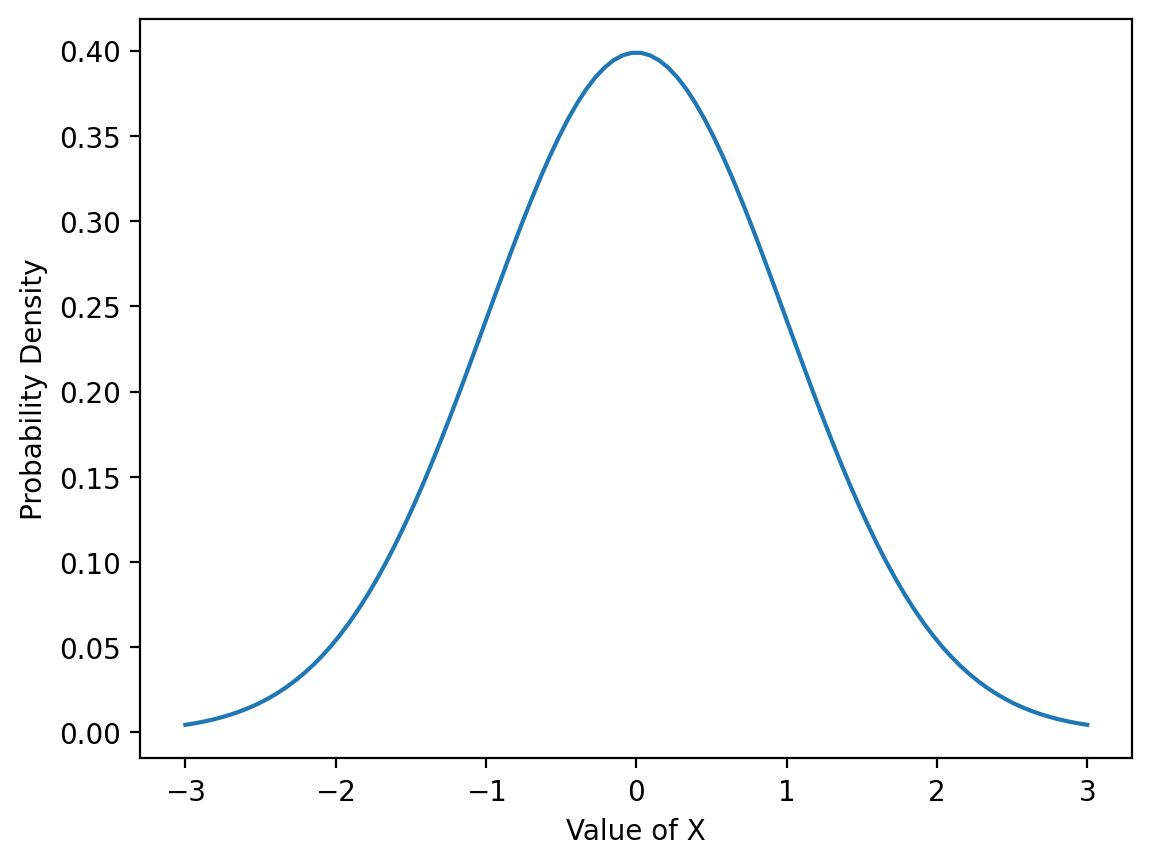

In [15]:
# Plot
sns.lineplot(x = X, y = pdf)
plt.xlabel("Value of X")
plt.ylabel("Probability Density")

### Different distributions, different classes

- Recall that we want to estimate $P(X | Y=k)$.  
- That means we want a density function for *each class $k$.  
- Thus, for each class $k$...
   - Estimate the *mean* $\mu_k$ for the feature $X$. 
   - Estimate the *standard deviation* $\sigma_k$ for the feature $X$. 
- Thus, we have a *specific* normal distribution for each class.

$P(x | Y = k) = \frac{1}{\sigma_k\sqrt{2\pi}}*e^{(-\frac{1}{2\sigma_k^2}(x - \mu_k)^2)}$

- In LDA, we also assume **equal variance** across classes, i.e., we calculate only a single $\sigma$.

#### Check-in

How would we put this *density function* back into our LDA / Bayes' Theorem equation?

In [17]:
### Your answer here

### Back to LDA

- Calculating $P(Y = k|X_i)$ will require both:
   - $P(k)$: the proportion of observations assigned to class $k$. 
   - $P(x_i | Y = k)$: the *probability* for $X_i$, for class $k$. 
- If we calculate this for each *class* $k$, we will get a probability $P(Y = k|X_i)$ for each class.
- Then, we just assign a label to $X_i$ based on whichever class $k$ gets the highest probability. 
- Though, we can make this a bit simpler...

### A simpler mathematical formulation

- Through some simplification, this equation simplifies to:

$\Large \delta_k(x) = x * \frac{\mu_k}{\sigma^2} - \frac{\mu^2_k}{2\sigma^2} + log(P(k))$

- Again, we assign a class $k$ to $x$ based on whichever class $k$ gets the highest score.  
- If $n = 2$ and $p(k_1) = p(k_2)$, this amounts to a **decision boundary** between two classes:

$\Large x = \frac{\mu_1 + \mu_2}{2}$

#### Decision boundaries: an example (pt. 1)

- Build two normal distributions with different $\mu$ but same $\sigma$.  


In [25]:
# Create distributions
X = np.linspace(-5, 5, num = 1000)

# Compute the PDF
X1_pdf = ss.norm.pdf(X, loc = -2, scale = 1)
X2_pdf = ss.norm.pdf(X, loc = 2, scale = 1)

#### Decision boundaries: an example (pt. 2)

- Now, plot the density functions for those distributions.

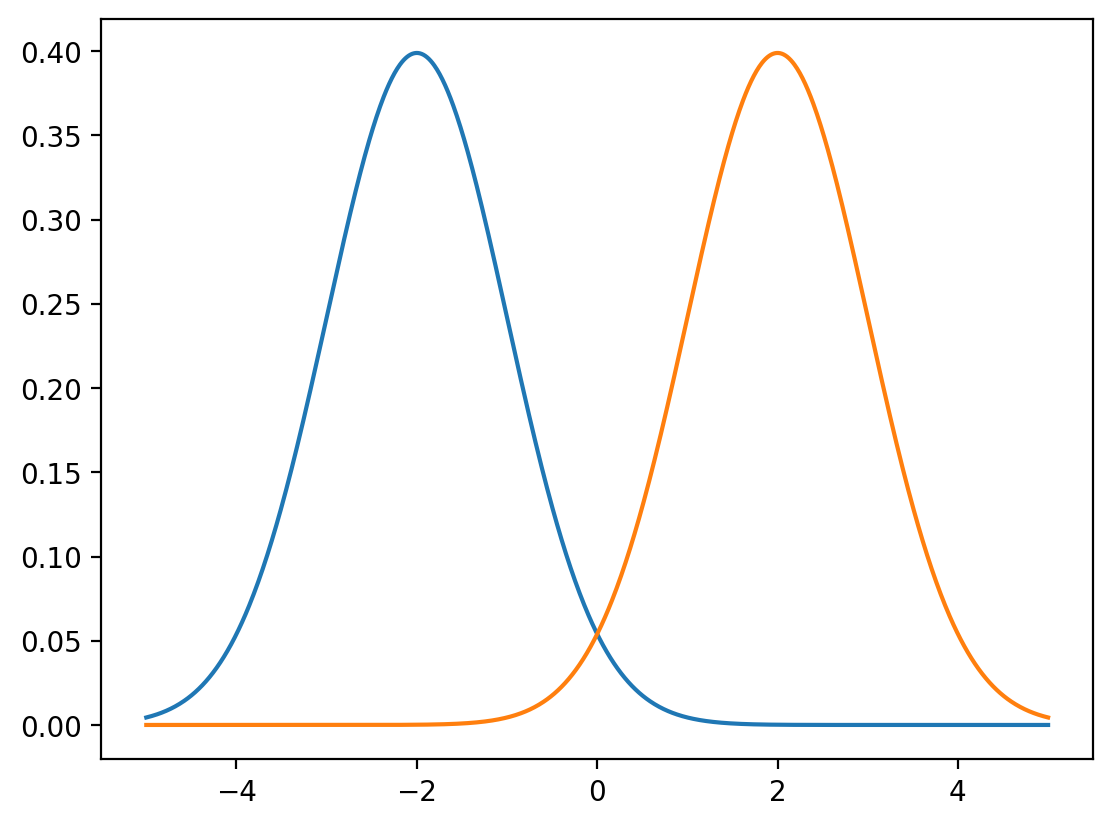

In [28]:
# Plot
plt.plot(X, X1_pdf)
plt.plot(X, X2_pdf)

#### Decision boundaries: an example (pt. 3)

- $x = \frac{\mu_1 + \mu_2}{2}$: **decision boundary** between two classes.  
- If some observation $X_i > x$, assign it $k_2$.
- If some observation $X_i < x$, assign it $k_1$.

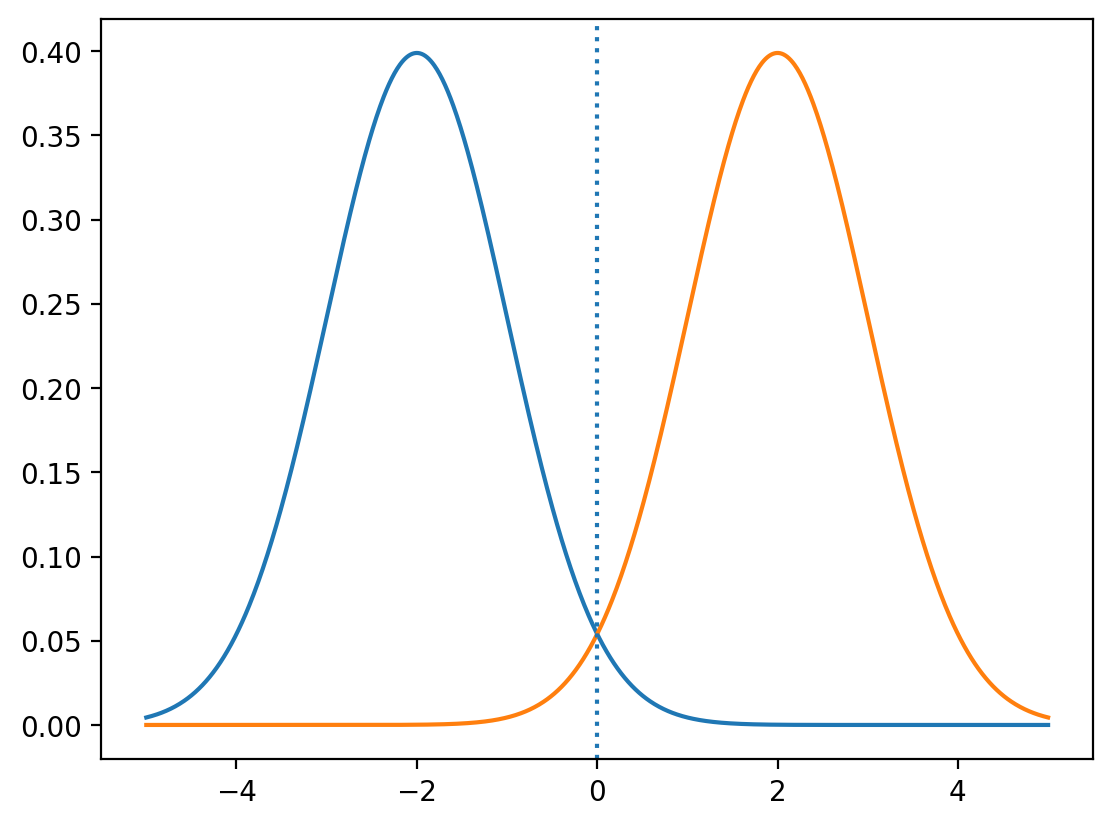

In [30]:
boundary = (-2 + 2) / 2

# Plot
plt.plot(X, X1_pdf)
plt.plot(X, X2_pdf)
plt.axvline(x = boundary, linestyle = "dotted")

### LDA: An interim summary

- **Basic goal**: classify observations $X$ into some classes ${k_1, k_2, ..., k_n}$. 
- **Intuition**: $P(Y = k | X)$ can be estimated using:
  - The *prior* probability of that class $k$.  
  - The *density function* over $X$, given $k$.
- To calculate that density function, we make some **simplifying assumptions**. 
  - Assume each distribution $P(X|Y=k)$ is normal.  
  - Assume each distribution has *same variance*.
- Ultimately, this gives us an equation for categorizing observations into classes based on some **decision boundary**. 
   - This is called the **discriminant function**.
   
$\delta_k(x) = x * \frac{\mu_k}{\sigma^2} - \frac{\mu^2_k}{2\sigma^2} + log(P(k))$

- LDA is **linear** because this equation is a *linear* function of our feature $X$.

## LDA in practice (from scratch)

- In this section, we'll discuss how to *apply* LDA to simulated data.  
- We'll first do this *from scratch*, using a simple example.
- In doing so, we'll also get more intuition for how LDA works.

### A simulated dataset

- First, let's load a simulated dataset I created.  
- Contains information about whether some transcation was `Fraud` or `Not Fraud`, as well as the `Amount` of transaction.

In [65]:
df_fraud = pd.read_csv("data/classification/simulated_fraud.csv")
df_fraud.head(2)

,Fraud,Amount
0,Not Fraud,67.205299
1,Not Fraud,105.287537


### Visualize our distributions

What do you notice about:

- The **shape** of our distributions?  
- The **variance** of our distributions?  
- Any **differences** between our classes?

/Users/seantrott/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


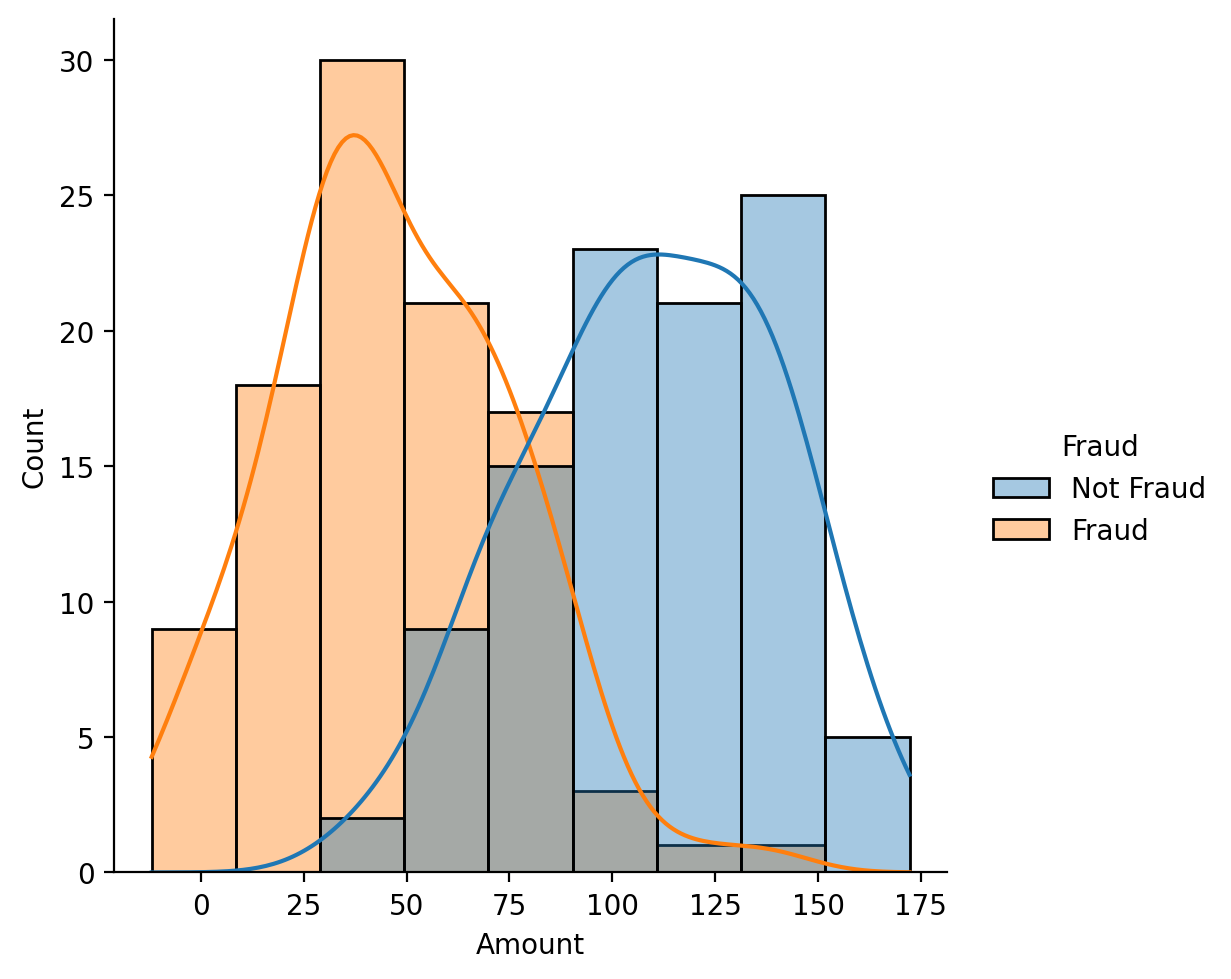

In [72]:
sns.displot(data = df_fraud, x = "Amount",
            hue = "Fraud", kde = True, alpha = .4)

### Implementing LDA from scratch

Now, let's calculate our **discriminant function** for each observation for each class $k$.

$\delta_k(x) = x * \frac{\mu_k}{\sigma^2} - \frac{\mu^2_k}{2\sigma^2} + log(P(k))$

To do this, we need:

- The prior $P(k)$ of each class.  
- The mean $\mu_k$ for each class.

Recall that we assume *equal variance* $\sigma$ across classes.


#### Step 1: calculate $p(k)$

- To calculate $p(k)$, we simply calculate the proportion of values corresponding to each class.  
- In this case, $p(k_1) = p(k_2)$. 

In [74]:
df_fraud['Fraud'].value_counts()/len(df_fraud)

Fraud
Not Fraud    0.5
Fraud        0.5
Name: count, dtype: float64

#### Step 2: calculate $\mu_k$

- Now, we calculate the *mean* of `Amount` for each class.

In [76]:
means = df_fraud.groupby("Fraud").mean()
means

,Amount
Fraud,
Fraud,46.999056
Not Fraud,109.909756


In [77]:
mu_fraud = means['Amount']['Fraud']
mu_nf = means['Amount']['Not Fraud']

#### Step 3: calculate $\sigma$

- We also calculate a single $\sigma$ parameter. 
- Simple approach: $\sigma$ for each class, then take the average.

In [81]:
sigmas = df_fraud.groupby("Fraud").std()
sigmas

,Amount
Fraud,
Fraud,28.410196
Not Fraud,30.056396


In [82]:
mean_sigma = sigmas.mean()
mean_sigma

Amount    29.233296
dtype: float64

#### Step 4a: Plug into formula!

- Finally, for each observation `Amount`, we calculate the **discriminant function** for each class $k$. 

$\delta_k(x) = x * \frac{\mu_k}{\sigma^2} - \frac{\mu^2_k}{2\sigma^2} + log(P(k))$

In [83]:
def discriminant(x, mu, pk, sigma):
    return x * (mu/sigma**2) - (mu**2)/(2 * sigma**2) + np.log(pk)

#### Step 4b: Plug into formula!

- Let's first calculate the discriminant function for `Fraud`.

In [87]:
df_fraud['d_Fraud'] = df_fraud['Amount'].apply(lambda x: discriminant(x,
                                                                     mu = mu_fraud,
                                                                     pk = .5,
                                                                     sigma = mean_sigma))

#### Step 4c: Plug into formula!

- Now for `Not Fraud`.

In [88]:
df_fraud['d_NotFraud'] = df_fraud['Amount'].apply(lambda x: discriminant(x,
                                                                     mu = mu_nf,
                                                                     pk = .5,
                                                                     sigma = mean_sigma))

#### Step 4d: A simpler approach

- Technically, because there are only two classes, and because $p(k_1) = p(k_2)$, we could've used
a simpler formula for our **decision boundary**.
- Simpler formula: $x = \frac{\mu_1 + \mu_2}{2}$

#### Step 5a: apply decision boundary

- If $\delta_{k1}(x) > \delta_{k2}(x)$, assign to $k_1$; else $k_2$

In [90]:
def make_decision(row):
    if row['d_NotFraud'] > row['d_Fraud']:
        return 0
    else:
        return 1
    
df_fraud['Decision'] = df_fraud.apply(make_decision, axis = 1)

#### Step 5b: visualize decision boundary

In [104]:
boundary = (mu_fraud + mu_nf)/2

/Users/seantrott/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


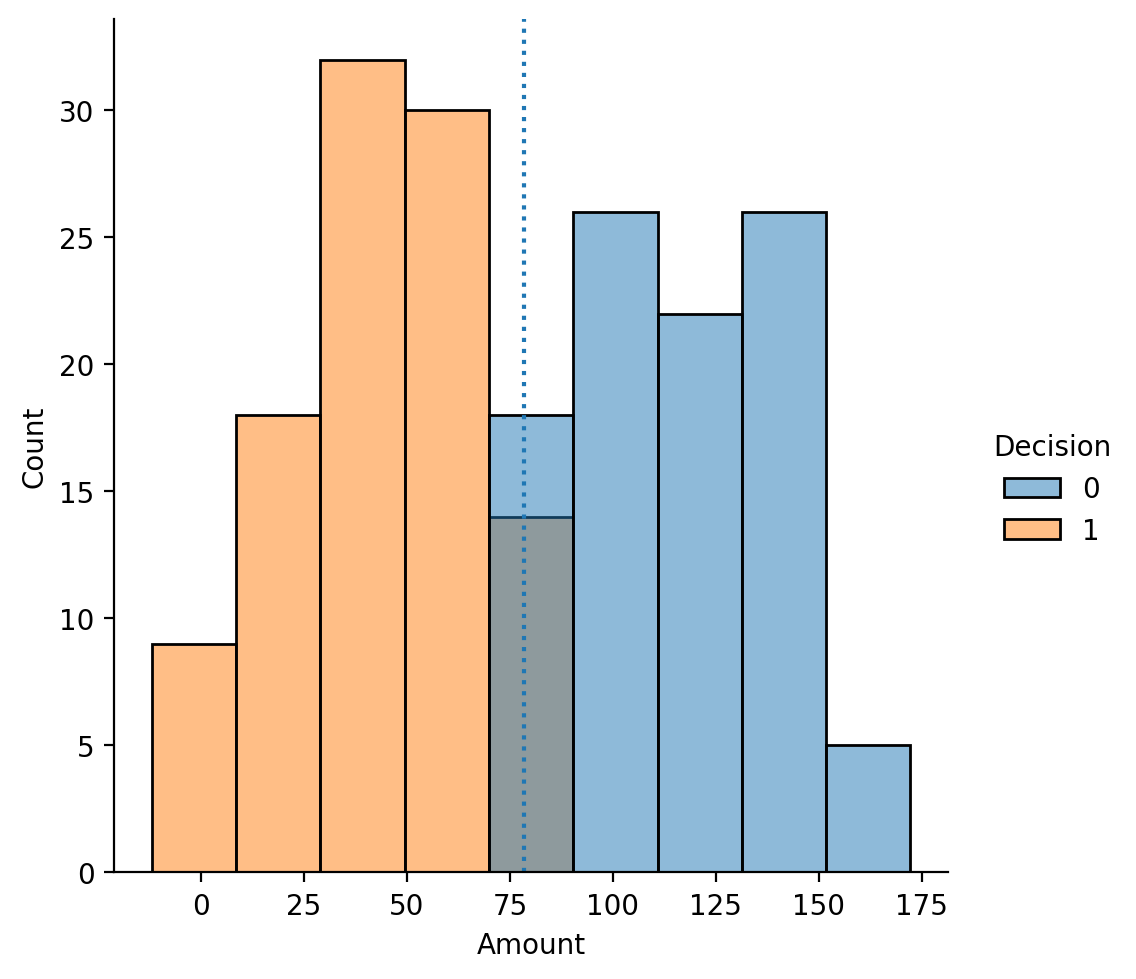

In [108]:
sns.displot(data = df_fraud, x = "Amount", hue = 'Decision')
plt.axvline(x = boundary, linestyle = "dotted")

#### Step 6: Analyze results

- Using this approach, we assign `Fraud` to actual `Fraud` cases a higher proportion of the time!

Text(0, 0.5, 'P(Fraud | Amount)')

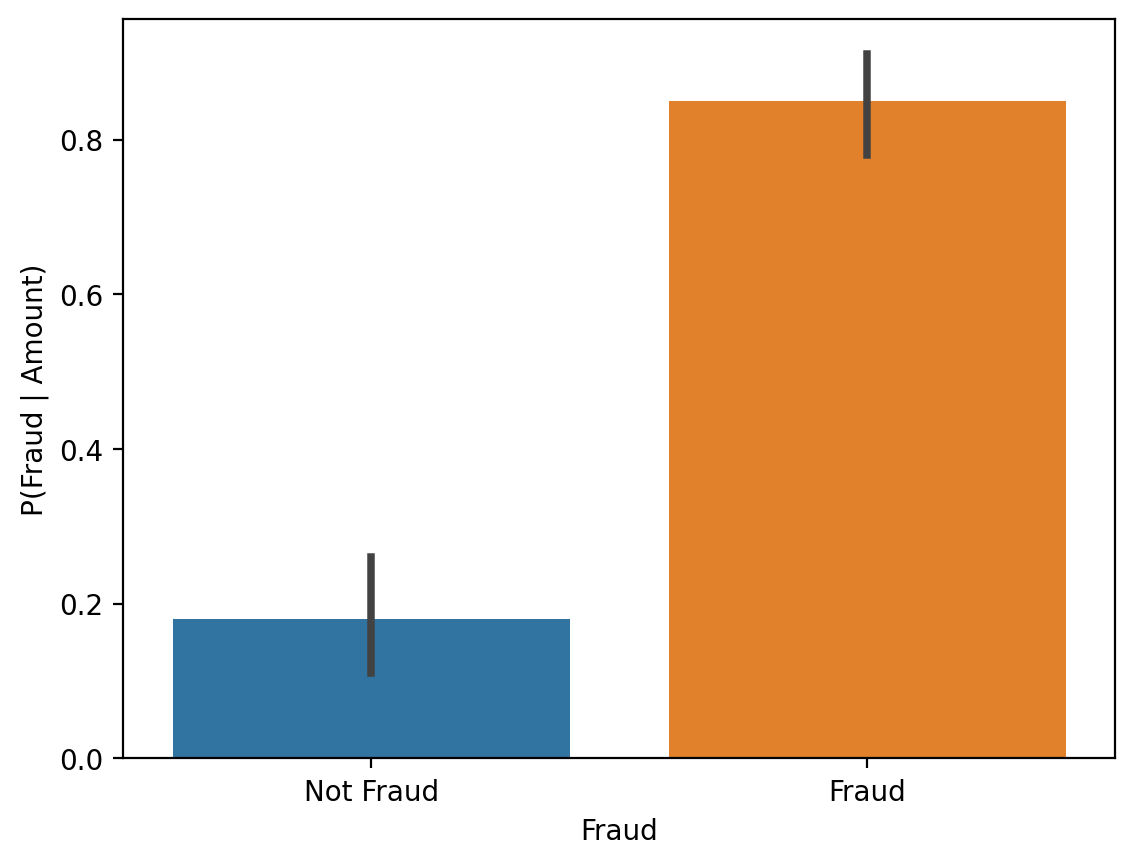

In [109]:
sns.barplot(data = df_fraud, x = "Fraud", y = "Decision")
plt.ylabel("P(Fraud | Amount)")

#### Step 7: Calculate accuracy

- *Hit rate*: we capture $85\%$ of `Fraud`.  
- *False positive rate*: we incorrectly categorize $15\%$ of `Not Fraud` as `Fraud`. 
- Overall, then, our accuracy is approximately $85\%$.

In [111]:
df_fraud[['Fraud', 'Decision']].groupby("Fraud").mean()

,Decision
Fraud,
Fraud,0.85
Not Fraud,0.18


### Wrapping up: LDA from scratch

- We've now implemented a simple version of LDA from scratch!  
- When $k = 2$ and there's only one feature, the implementation is actually pretty simple.  
   - Essentially amounts to the difference between means, *weighted* by prior probability of each class. 
- That's because we make some **simplifying assumptions**.  
   - Assume each distribution is normal.  
   - Assume equal variance across distributions.
- The same logic applies when $k > 2$ and $p > 1$, but it is slightly more complicated.

## LDA in practice (in Python)

- Now that we've implemented a simple version of LDA from scratch, let's look at some real data.  
- We'll use the `sklearn` implementation of **LDA**.

**Note**: For some of these demonstrations, we won't yet be using cross-validation, but in practice you should!

In [114]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

### Load the `iris` dataset

- The `iris` dataset contains information about the size of different species of flower.

In [138]:
df_iris = pd.read_csv("data/classification/iris.csv")
df_iris.head(2)

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),species
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0


### Exploring the dataset

- There are three classes, so $k = 3$.  
- Each class has four features (two pictured here).

<Axes: xlabel='petal length (cm)', ylabel='petal width (cm)'>

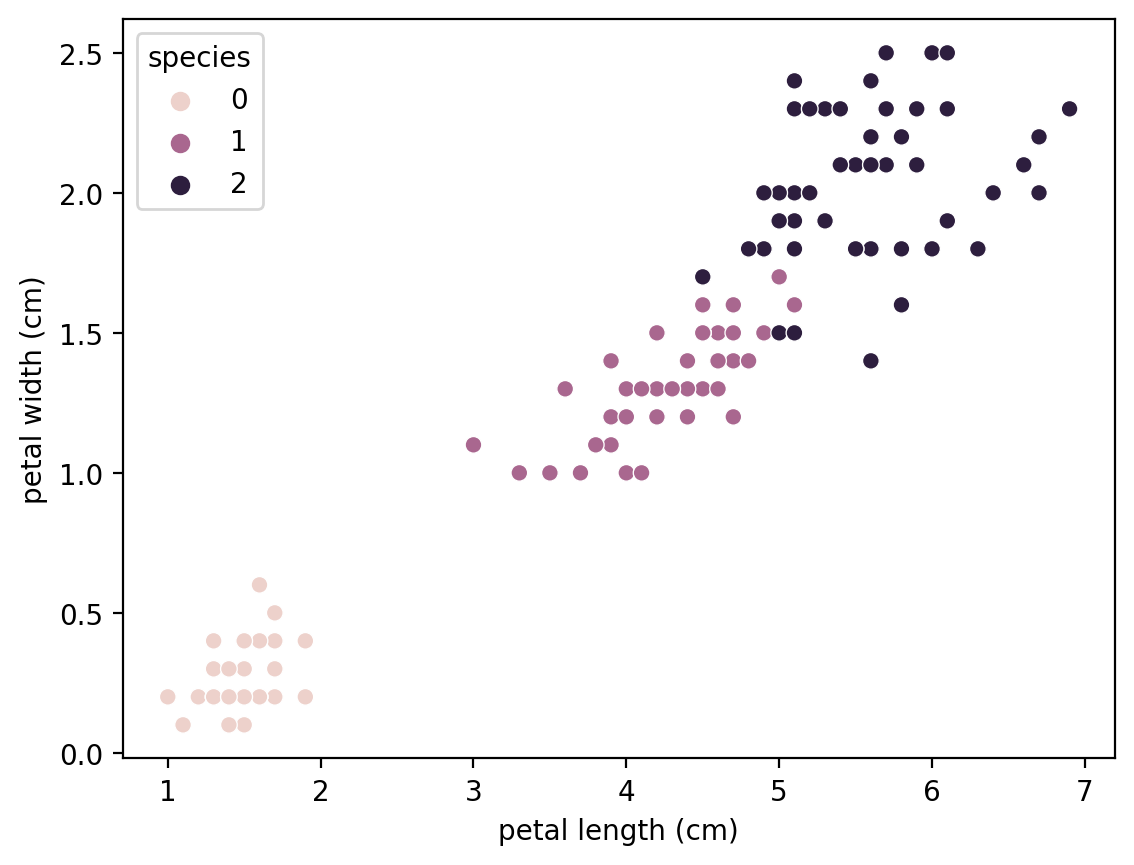

In [113]:
sns.scatterplot(data = df_iris, x = "petal length (cm)",
               y = "petal width (cm)",
               hue = "species")

### Implementation 1: a simple approach

- To start with, let's try just using `petal length` and `petal width`.  
- Let's also limit our analysis to just *two species*. 

In [116]:
## Focus on species 0 and 1
df_subset = df_iris[df_iris['species'] != 2]
df_subset['species'].value_counts()

species
0    50
1    50
Name: count, dtype: int64

In [119]:
X = df_subset[['petal length (cm)', 'petal width (cm)']].values
y = df_subset['species'].values

#### Fit our `lda` model

In [117]:
lda = LinearDiscriminantAnalysis()

In [120]:
lda.fit(X, y)

LinearDiscriminantAnalysis()

#### Use `lda.predict`

In [122]:
y_pred = lda.predict(X)
df_subset['y_pred'] = y_pred

/var/folders/pn/5zbmv0cj31v6hmyh53njhmdw0000gn/T/ipykernel_13348/2004210602.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_subset['y_pred'] = y_pred


#### Side note: `predict_proba`

- The `predict_proba` method will generate a **distribution** of probabilities over classes.  
- Can be useful for debugging classifier and figuring out strength of predictions.

In [124]:
lda.predict_proba(X)[0:5]

array([[1.00000000e+00, 1.00597485e-15],
       [1.00000000e+00, 1.00597485e-15],
       [1.00000000e+00, 1.77219615e-16],
       [1.00000000e+00, 5.71034646e-15],
       [1.00000000e+00, 1.00597485e-15]])

#### Visualize predictions

- These classes are very well separated!

<Axes: xlabel='petal length (cm)', ylabel='petal width (cm)'>

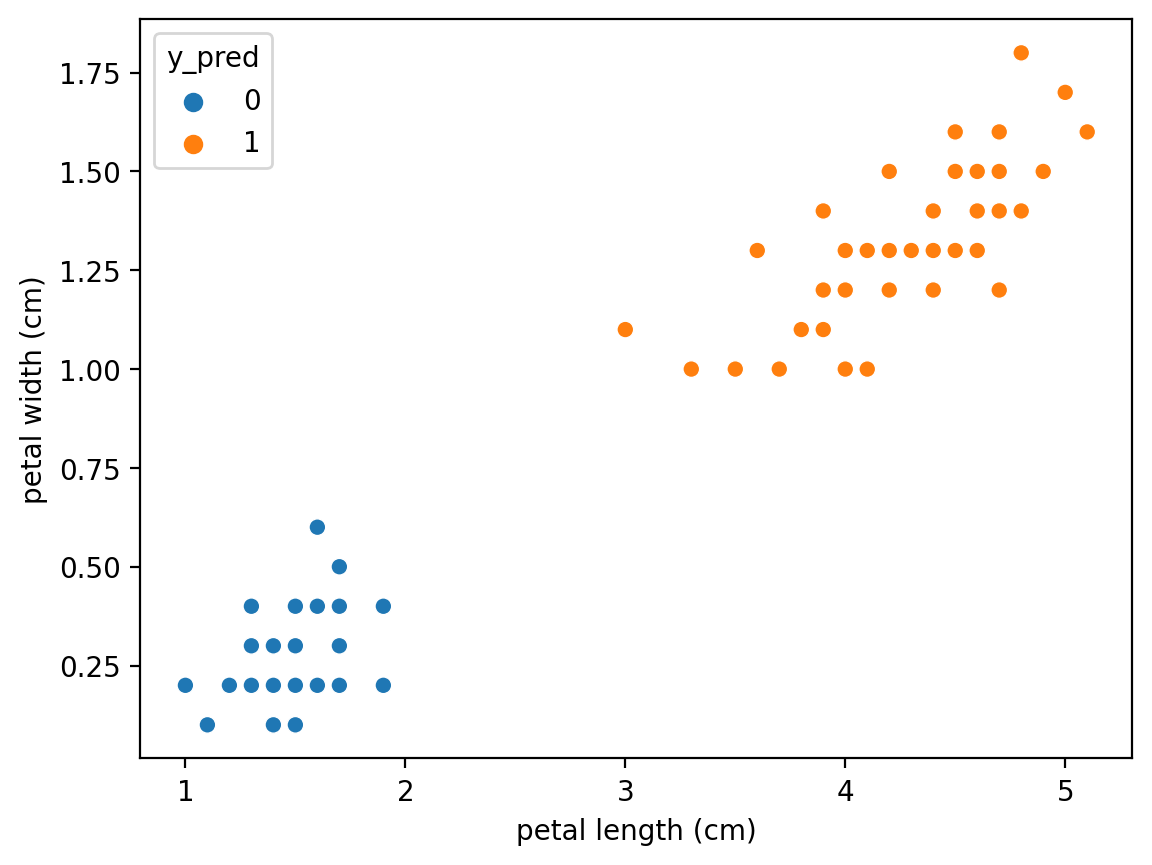

In [126]:
sns.scatterplot(data = df_subset, x = "petal length (cm)",
               y = "petal width (cm)",
               hue = "y_pred")

### More features, more classes

- Now, let's use our original dataset with all three `species`. 
- Let's also use three of the features available to us.

#### Check-in

- Fit an `lda` model using the entire iris dataset.  
- Use three of the four possible features.

In [132]:
### Your code here

#### Using all our features

In [135]:
X = df_iris[['petal length (cm)', 'petal width (cm)', 'sepal length (cm)']].values
y = df_iris['species'].values

In [136]:
### fit the model
lda.fit(X, y)

LinearDiscriminantAnalysis()

In [139]:
### get predictions
y_pred = lda.predict(X)

#### Analyzing predictions

In [140]:
from sklearn.metrics import accuracy_score, classification_report

In [142]:
report = classification_report(y, y_pred) 
print(report)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        50
           1       0.96      0.96      0.96        50
           2       0.96      0.96      0.96        50

    accuracy                           0.97       150
   macro avg       0.97      0.97      0.97       150
weighted avg       0.97      0.97      0.97       150



### LDA for dimensionality reduction

- One advantage of LDA is as a kind of **supervised dimensionality reduction**.  
- Instead of looking at our original features, we can look at some *lower-dimensional space* that LDA uses to separate our classes.  
- This can be found in the `lda.scalings_` parameter.  
   - Especially useful when $p>2$, because we can't visualize all the features at once easily.

In [143]:
lda.scalings_

array([[ 2.71900406, -2.61927689],
       [ 2.0354452 ,  4.71964724],
       [-1.53902222,  1.59124563]])

#### Using `lda.scalings_` (pt. 1)

- To use these, multiply them by original feature matrix.

In [145]:
# To project your data onto the LDA components
X_projected = X.dot(lda.scalings_)
X_projected[0:2]

array([[-3.63531862,  5.39229454],
       [-3.32751418,  5.07404541]])

#### Visualizing `lda.scalings_` (pt. 2)

Text(0, 0.5, 'Discriminant 2')

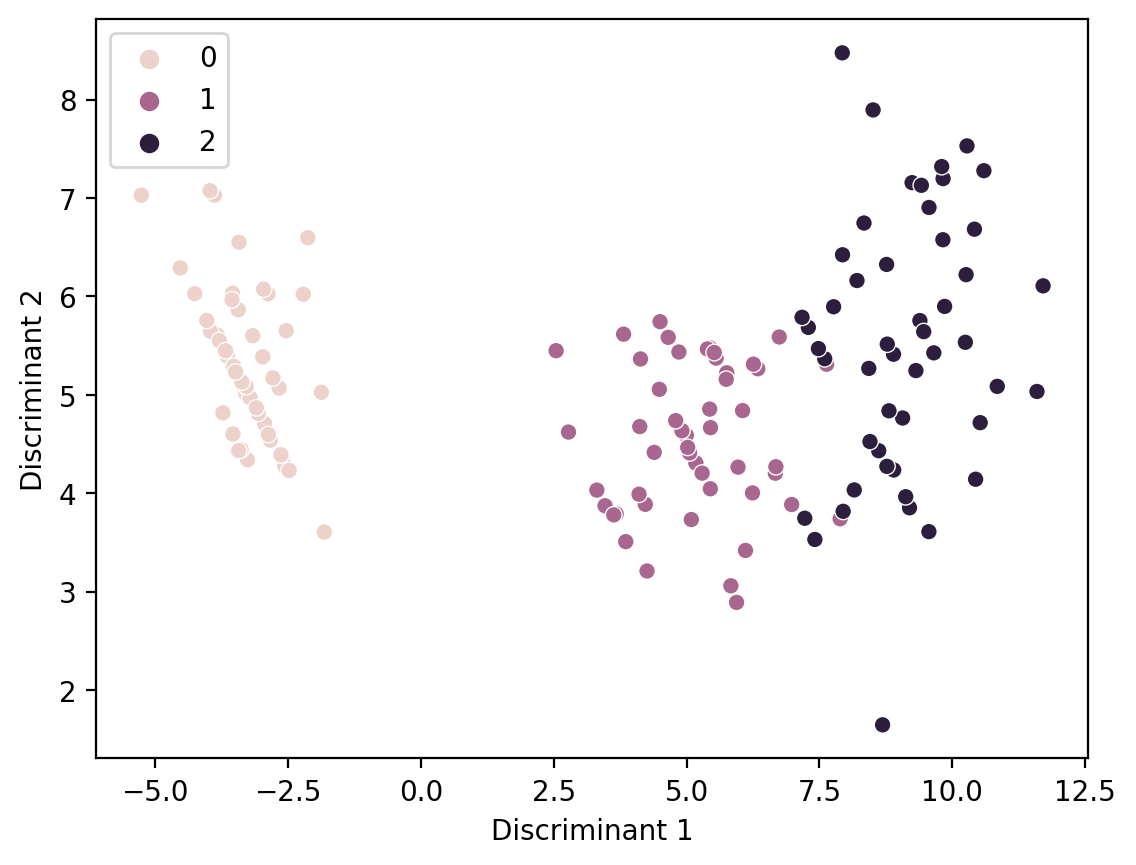

In [148]:
sns.scatterplot(x = X_projected[:,0],
               y = X_projected[:,1],
               hue = y)
plt.xlabel("Discriminant 1")
plt.ylabel("Discriminant 2")

### One final approach: all four features!

#### First, fit model

In [149]:
X = df_iris[['petal length (cm)', 'petal width (cm)', 'sepal length (cm)', 'sepal width (cm)']].values
y = df_iris['species'].values

In [150]:
### fit the model
lda.fit(X, y)

LinearDiscriminantAnalysis()

In [151]:
### get predictions
y_pred = lda.predict(X)

#### Analyzing predictions

In [152]:
report = classification_report(y, y_pred) 
print(report)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        50
           1       0.98      0.96      0.97        50
           2       0.96      0.98      0.97        50

    accuracy                           0.98       150
   macro avg       0.98      0.98      0.98       150
weighted avg       0.98      0.98      0.98       150



#### Visualizing `lda.scalings_` 

In [154]:
# To project your data onto the LDA components
X_projected = X.dot(lda.scalings_)

Text(0, 0.5, 'Discriminant 2')

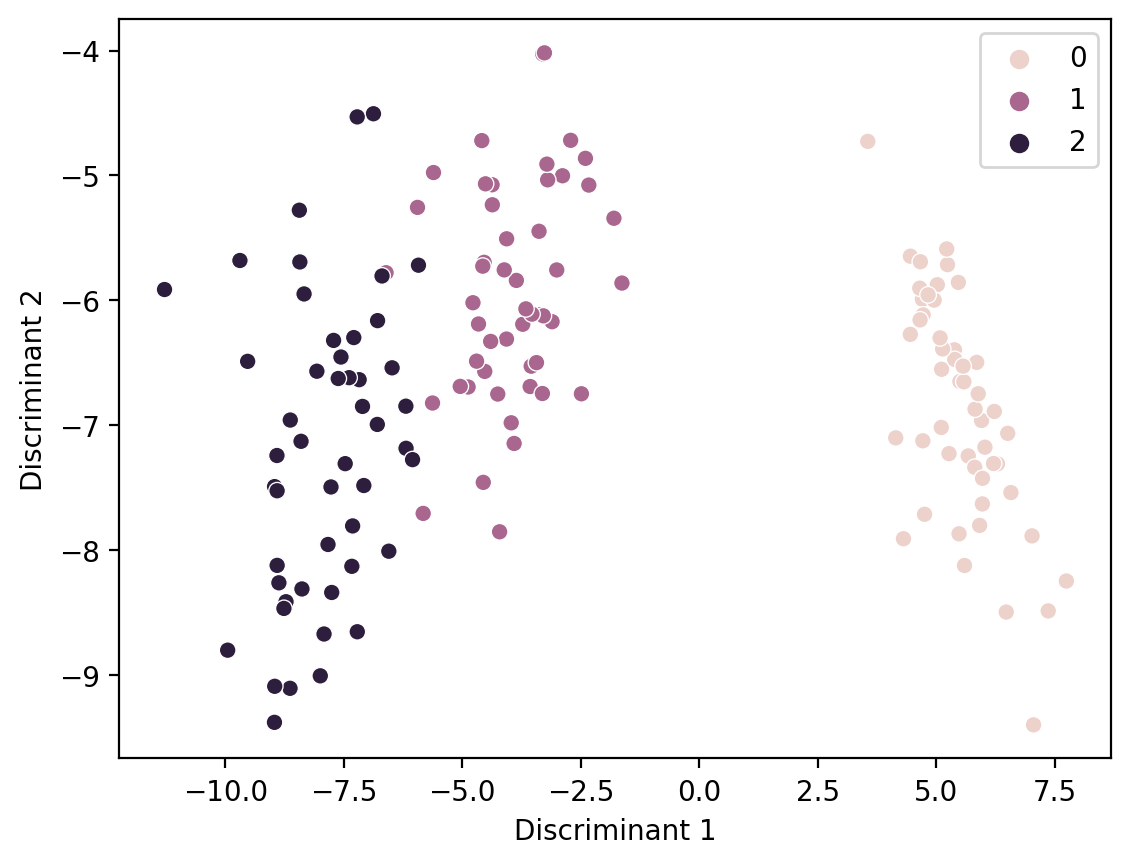

In [157]:
sns.scatterplot(x = X_projected[:,0],
               y = X_projected[:,1],
               hue = y)
plt.xlabel("Discriminant 1")
plt.ylabel("Discriminant 2")

## Lecture wrap-up

- **Linear discriminant analysis (LDA)** is a powerful and interpretable method for classification.  
  - Based on **Bayes' Theorem**.
- Also makes strong assumptions about *normality* and *shared variance*. 
- Various *extensions* that relax these assumptions, grounded in similar principles.  